In [ ]:
!pip install torch torchaudio librosa

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F
import librosa
import math

In [ ]:
def plot_audio_feature(specgram, title=None, ylabel=None):
    """ visualize mel spectrogram && log mel spectrogram """
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Mel Spectrogram")
    axs.set_ylabel(ylabel=ylabel)
    axs.set_xlabel("frames")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [ ]:
def get_melspectrogram(array):
    """
    :param array: audio array get by torchaudio
    :return: log mel spectrogram
    """

    # define mel spec transform function
    F_mel = T.MelSpectrogram(
        sample_rate=22050,
        n_fft=640,
        win_length=640,
        hop_length=321,
        window_fn=eval("torch.hamming_window"),
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        n_mels=81,
        mel_scale="slaney",
    )

    # get mel spectrogram
    mel_spectrogram = F_mel(array)

    # log mel spectrogram
    # log_melspectrogram = F.amplitude_to_DB(mel_spectrogram, multiplier=10, amin=1e-10,
    #                                        db_multiplier=math.log10(max(1e-10, 1)))

    # adjust output
    # return log_melspectrogram.squeeze(0).transpose(0, 1).contiguous()
    return mel_spectrogram.squeeze(0)

In [ ]:
def audio_transforms(array):
    """
    :param array: audio array get by torchaudio
    :param params: params config in yaml file
    :return: log mel spectrogram
    """

    # define mel spec transform function
    F_mel = T.MelSpectrogram(
        sample_rate=16000,
        n_fft=640,
        win_length=640,
        hop_length=321,
        window_fn=eval("torch.hamming_window"),
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        n_mels=81,
        mel_scale="slaney",
    )

    # get mel spectrogram
    mel_spectrogram = F_mel(array)

    # log mel spectrogram
    log_melspectrogram = F.amplitude_to_DB(mel_spectrogram, multiplier=10, amin=1e-10,
                                           db_multiplier=math.log10(max(1e-10, 1)))

    # adjust output
    # standard output: [bannks, n_frames (times)]
    # the banks can be represent the in channels for CNN can be considered as standard channels,
    # the n_frames cannot be channels because the data in not consistent in distribution in n_frames (time).
    return log_melspectrogram.squeeze(0)

In [ ]:
aarray, rate = torchaudio.load('test.flac')

### MEL SPECTROGRAM

In [ ]:
melspec = get_melspectrogram(aarray)

In [ ]:
log_melspec = audio_transforms(aarray)

In [ ]:
log_melspec.shape

torch.Size([81, 105])

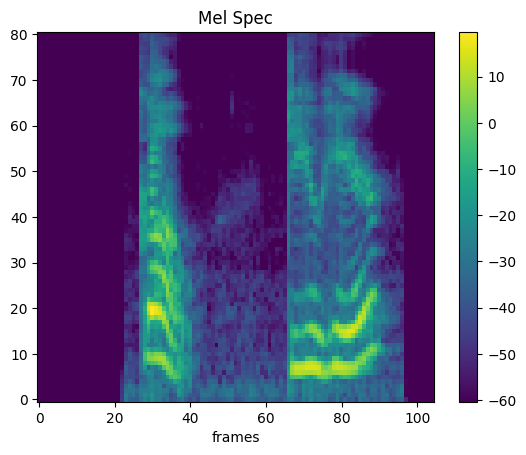

In [ ]:
plot_audio_feature(melspec, title="Mel Spec")

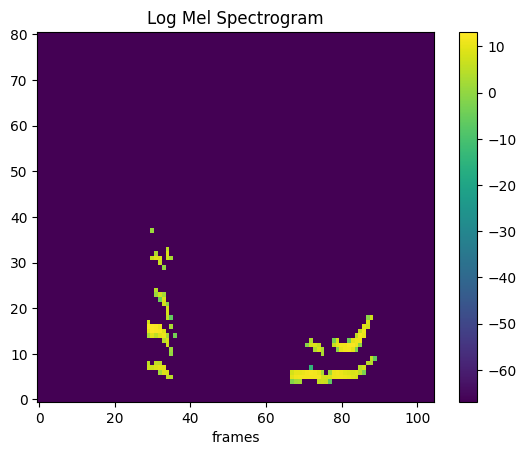

In [ ]:
plot_audio_feature(log_melspec, title="Log Mel Spectrogram")

# Conv2D SubSampling -> subsample 4 times

In [ ]:
import torch.nn as nn

In [ ]:
class ConvSubSampling(nn.Module):

    # Conv2D sub sampling implemented follow this guide
    def __init__(self, in_channels: int, out_channels: int,
                kernel_size: int = 3, stride: int = 2, padding: int = 0):
        super(ConvSubSampling, self).__init__()
        # stride = 2 -> expirement: using max pooling layer
        self.chain = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x - tensor(batch_size, channels (1), n_frames, fbanks) - input
        # Conv1D input - (batch_size, in_channels, out_channels)
        return self.chain(x)

# Conv2D subsampling object

In [ ]:
conv2d_subsampling = ConvSubSampling(in_channels=1, out_channels=64,
                                  kernel_size=3, padding=0, stride=1)

# Mel Spec after Conv2D

In [ ]:
out_mel = conv2d_subsampling(melspec.unsqueeze_(0))
out_mel.shape

torch.Size([64, 77, 101])

In [ ]:
melspec_outcnn = torch.sum(out_mel, dim=0)
melspec_outcnn.shape

torch.Size([77, 101])

# Mel spec after Conv2D

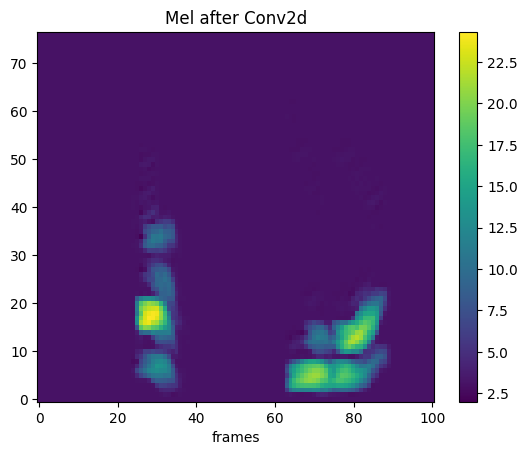

In [ ]:
plot_audio_feature(melspec_outcnn.detach().numpy(), title="Mel after Conv2d")

# Log mel after Conv2D

In [ ]:
out = conv2d_subsampling(log_melspec.unsqueeze_(0))
out.shape

torch.Size([64, 77, 101])

In [ ]:
lmelspec_outcnn = torch.sum(out, dim=0)
lmelspec_outcnn.shape

torch.Size([77, 101])

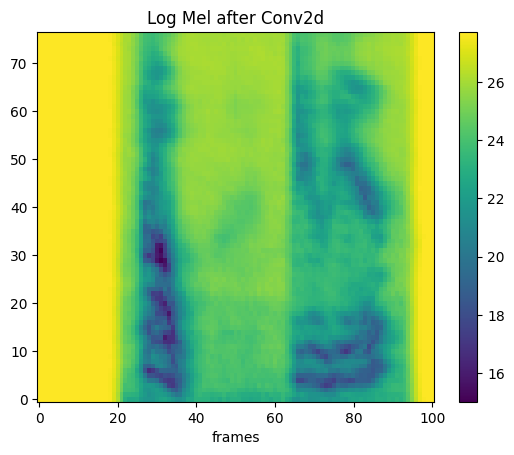

In [ ]:
plot_audio_feature(lmelspec_outcnn.detach().numpy(), title="Log Mel after Conv2d")